Extracted Features in Tabular Format:
        0       1       2       3       4       5       6       7       8    \
0  501271.0  2615.0  2893.0  2105.0  2611.0  2008.0  1749.0  1666.0  1825.0   
1  550146.0  2569.0  2940.0  2030.0  2767.0  2078.0  1816.0  1838.0  2016.0   
2  694464.0   862.0   775.0   702.0   632.0   585.0   656.0   700.0   654.0   
3  716953.0  2197.0  2473.0  1808.0  2467.0  1858.0  1612.0  1589.0  1755.0   
4  206523.0  8724.0  6254.0  5089.0  4487.0  4012.0  3651.0  3402.0  3229.0   

      9    ...       197       198      199       200           201  \
0  1481.0  ...  0.000000  0.000000  0.00000  0.000750  2.278964e-08   
1  1524.0  ...  0.000000  0.000000  0.00000  0.000796  2.501783e-08   
2   626.0  ...  0.000000  0.000000  0.00000  0.000800  2.441977e-08   
3  1276.0  ...  0.000000  0.000000  0.00000  0.000811  2.526818e-08   
4  2960.0  ... -4.006845  5.931514  7.91474  0.000734  2.198443e-08   

            202           203           204           205   

C:\Users\amans\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


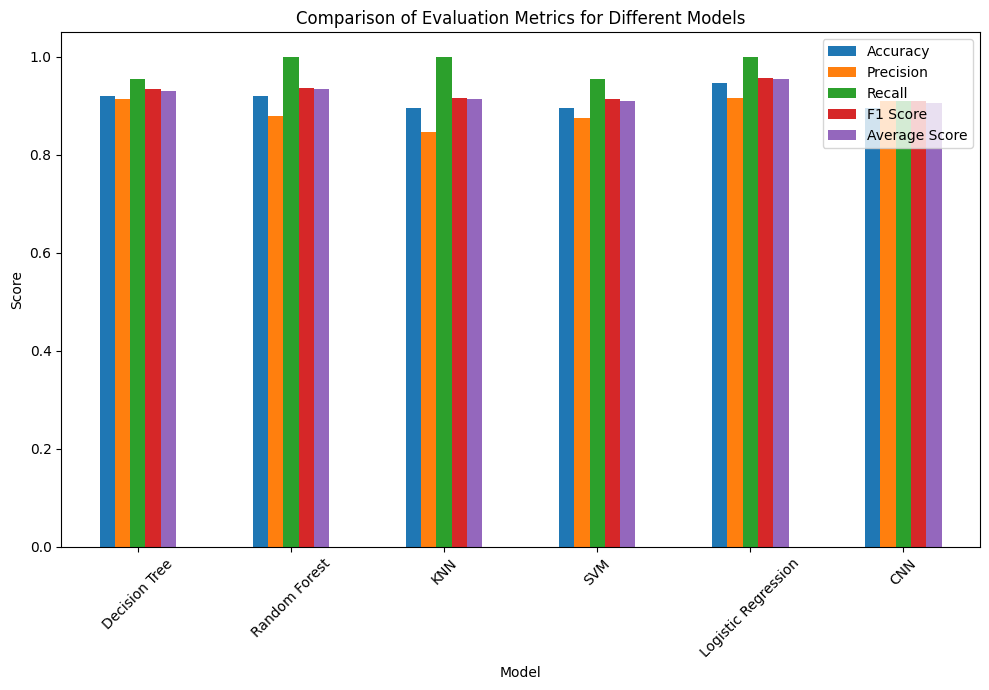

In [20]:
# all 6 model combine 
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

# Function to extract features from an image (replace with your feature extraction function)
def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray, (3600, 2916))
    hist = cv2.calcHist([resized_image], [0], None, [256], [0,256]).flatten()[:100]
   # Existing contour and Fourier descriptor calculation
    contours, _ = cv2.findContours(resized_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea) if contours else np.zeros(1)
    fourier_result = cv2.ximgproc.fourierDescriptor(contour).flatten()[:100] if contours else np.zeros(100)

    # Ensure fourier_result is always of length 100
    fourier_result = np.pad(fourier_result, (0, max(0, 100 - fourier_result.size)), 'constant', constant_values=0)

    moments = cv2.moments(resized_image)
    hu_moments = cv2.HuMoments(moments).flatten()[:100]
   
     
    return np.concatenate([hist, fourier_result, hu_moments])




import os

# Function to collect image paths and assign labels dynamically
def collect_image_paths_and_labels(root_folder):
    image_paths = []
    labels = []
    for label, subfolder in enumerate(['non_cancer', 'cancer']):  # Assign label 0 for non_cancer and 1 for cancer
        folder_path = os.path.join(root_folder, subfolder)
        for filename in os.listdir(folder_path):
            if filename.endswith('.png') or filename.endswith('.tif'):  # Adjust extensions as needed
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(label)
    
    return image_paths, labels

# Assuming your images are stored in folders "non_cancer" and "cancer" within the current directory
root_folder =r"C:\Users\amans\Desktop\PROJECT\root\root"
image_paths, labels = collect_image_paths_and_labels(root_folder)

# Extract features from each image
features = []
for path in image_paths:
    image = cv2.imread(path)
    features.append(extract_features(image))

# Print extracted features in a tabular format
df_features = pd.DataFrame(features)
print("Extracted Features in Tabular Format:")
print(df_features.head())

# Convert to numpy arrays
X = np.array(df_features)
y = np.array(labels)

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Print PCA features in a row-column table
df_pca_features = pd.DataFrame(X_pca, columns=[f"PCA_{i}" for i in range(X_pca.shape[1])])
df_pca_features['label'] = y
print("\nPCA Features in Tabular Format:")
print(df_pca_features.head())

# Reshape data for CNN input (adjust the shape based on your PCA components)
X_reshaped = X_pca.reshape((X_pca.shape[0], X_pca.shape[1], 1))

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.3,stratify =y, random_state=42)

# Train Decision Tree classifier with PCA-reduced data
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

# Train Random Forest classifier with PCA-reduced data
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

# Train K-Nearest Neighbors classifier with PCA-reduced data
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

# Train Support Vector Machine classifier with PCA-reduced data
clf_svm = SVC()
clf_svm.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

# Train Logistic Regression classifier with PCA-reduced data
clf_lr = LogisticRegression()
clf_lr.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

# CNN architecture
model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_pca.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate each model with PCA-reduced test data and CNN test data
models = {
    'Decision Tree': clf_dt,
    'Random Forest': clf_rf,
    'KNN': clf_knn,
    'SVM': clf_svm,
    'Logistic Regression': clf_lr,
    'CNN': model
}

evaluation_results = {}
for model_name, model in models.items():
    if model_name != 'CNN':
        y_pred = model.predict(X_test.reshape((X_test.shape[0], -1)))
    else:
        y_pred = (model.predict(X_test) > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Calculate average score
    avg_score = np.mean([accuracy, precision, recall, f1])

    evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Average Score': avg_score
    }

# Print the evaluation results of all models
print("\nEvaluation Results for All Models:")
for model_name, metrics in evaluation_results.items():
    print(f"{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"    {metric_name}: {metric_value}")
    print()

# Determine the best model based on average score
best_model_name = max(evaluation_results, key=lambda x: evaluation_results[x]['Average Score'])
print(f"Best Model: {best_model_name} with Metrics: {evaluation_results[best_model_name]}")

# Plotting comparison of evaluation metrics
metrics_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Average Score']].plot(kind='bar', figsize=(10, 7))
plt.title('Comparison of Evaluation Metrics for Different Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

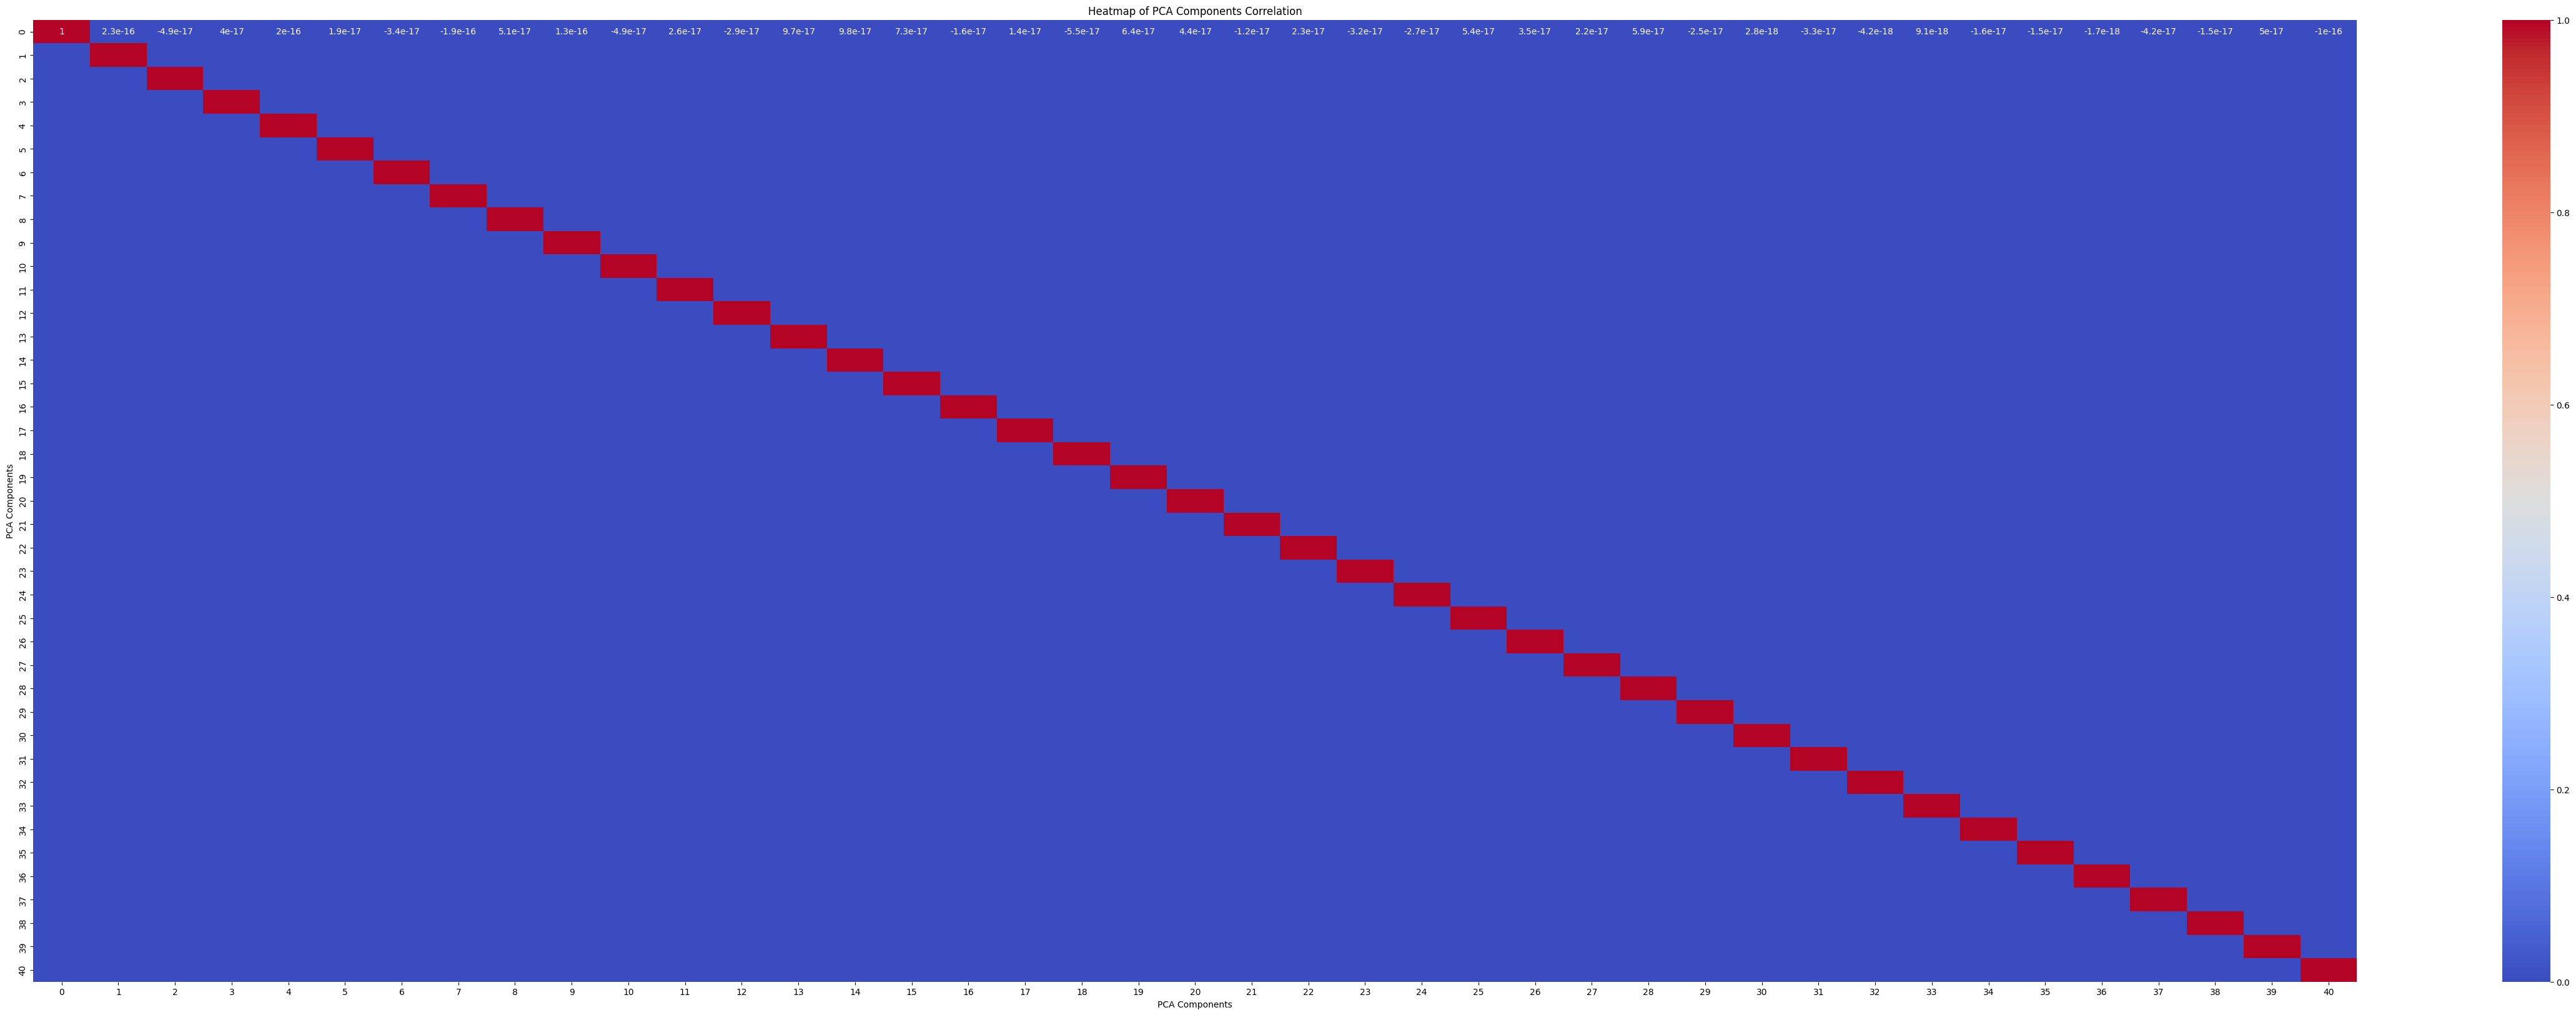

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_pca is your PCA-reduced feature set
corr_matrix = np.corrcoef(X_pca.T)  # Compute the correlation matrix for PCA components

plt.figure(figsize=(60, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of PCA Components Correlation')
plt.xlabel('PCA Components')
plt.ylabel('PCA Components')
plt.show()


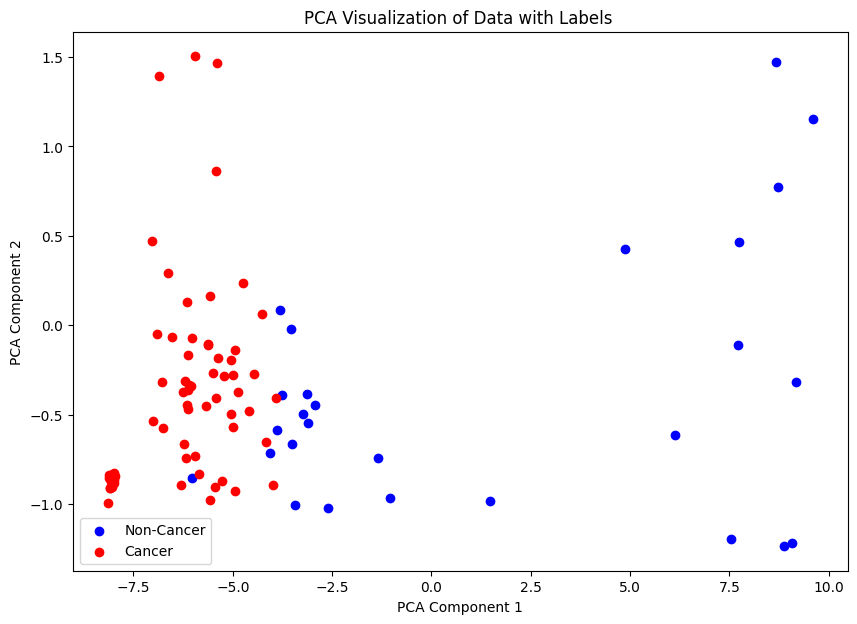

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming X_pca contains your PCA-reduced data and y contains the labels.

# Select the first two PCA components for visualization
X_for_visualization = X_pca[:, :2]

# Calculate z-scores for each feature in the data
z_scores = np.abs(stats.zscore(X_for_visualization))

# Define a threshold for z-score to identify outliers
threshold =1 # You can adjust this threshold as needed

# Find the indices of outliers
outlier_indices = np.where(z_scores > threshold)

# Remove outliers from X_for_visualization and y
X_filtered = np.delete(X_for_visualization, outlier_indices[0], axis=0)
y_filtered = np.delete(y, outlier_indices[0])

# Plotting
plt.figure(figsize=(10, 7))

# Plot data points without outliers
for label, color in zip([0, 1], ['blue', 'red']):  # Assuming 0 is non-cancer and 1 is cancer
    plt.scatter(X_filtered[y_filtered == label, 0], X_filtered[y_filtered == label, 1], c=color, label='Cancer' if label == 1 else 'Non-Cancer')

plt.title('PCA Visualization of Data with Labels ')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


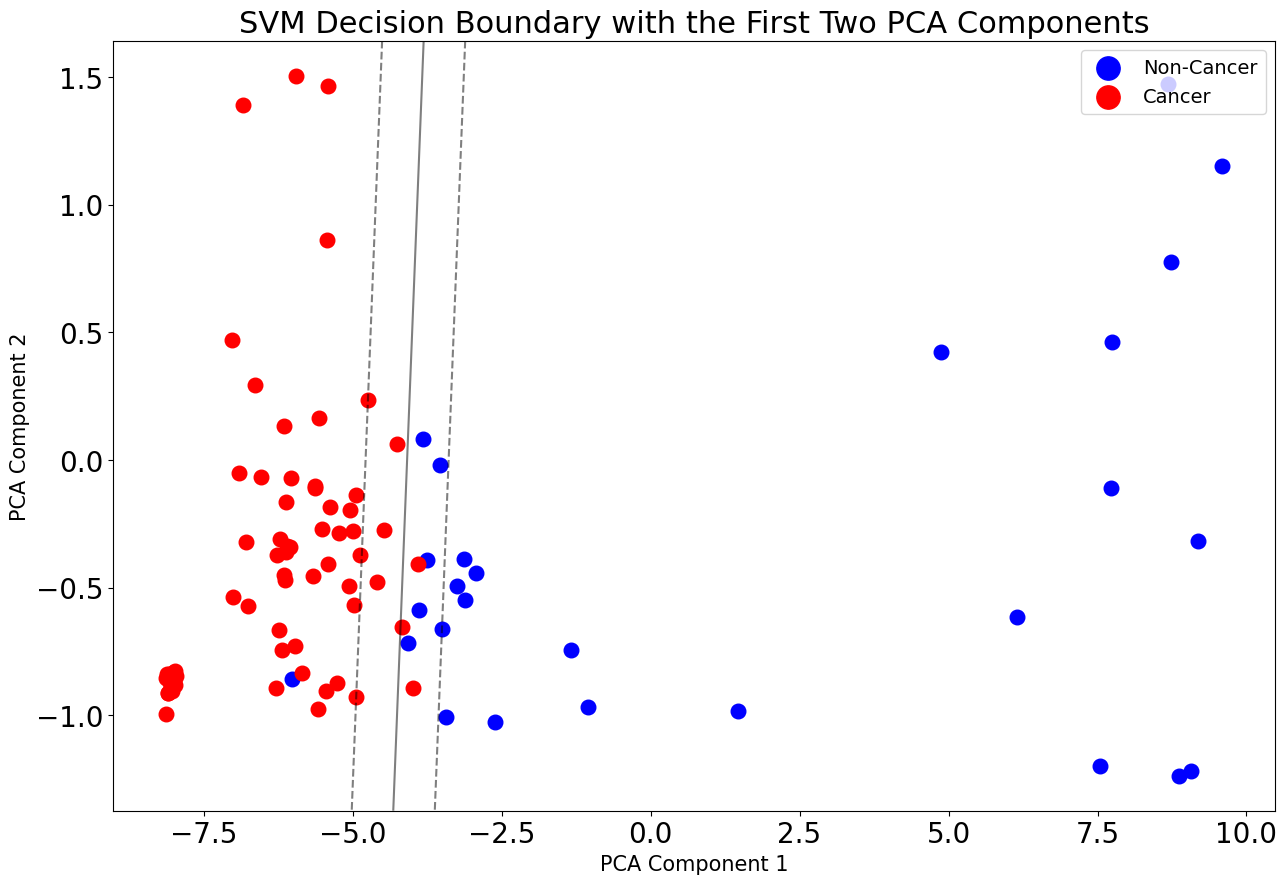

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy import stats

# Assuming X_pca contains your PCA-reduced data and y contains the labels.

# Select the first two PCA components for visualization
X_for_visualization = X_pca[:, :2]

# Calculate z-scores for each feature in the data
z_scores = np.abs(stats.zscore(X_for_visualization))

# Define a threshold for z-score to identify outliers
threshold = 1  # You can adjust this threshold as needed

# Find the indices of outliers
outlier_indices = np.where(z_scores > threshold)

# Remove outliers from X_for_visualization and y
X_filtered = np.delete(X_for_visualization, outlier_indices[0], axis=0)
y_filtered = np.delete(y, outlier_indices[0])

# Retrain SVM on the filtered data
clf_svm_visualization = SVC(kernel='linear')  # Make sure the kernel matches your original SVM model
clf_svm_visualization.fit(X_filtered, y_filtered)

# Plotting
plt.figure(figsize=(15, 10))

# Plot data points without outliers
for label, color, marker in zip([0, 1], ['blue', 'red'], ['o', 's']):  # Assuming 0 is non-cancer and 1 is cancer
    plt.scatter(X_filtered[y_filtered == label, 0], X_filtered[y_filtered == label, 1], c=color, label='Cancer' if label == 1 else 'Non-Cancer', marker='o', s=110)

# Plot decision boundary (hyperplane)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_svm_visualization.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Increase text size in the plot
plt.title('SVM Decision Boundary with the First Two PCA Components', fontsize=22)
plt.xlabel('PCA Component 1', fontsize=15)
plt.ylabel('PCA Component 2', fontsize=15)
plt.legend(loc='upper right', fontsize=14, markerscale=1.6)  # Legend at top right with increased font size and marker size
plt.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size

plt.show()


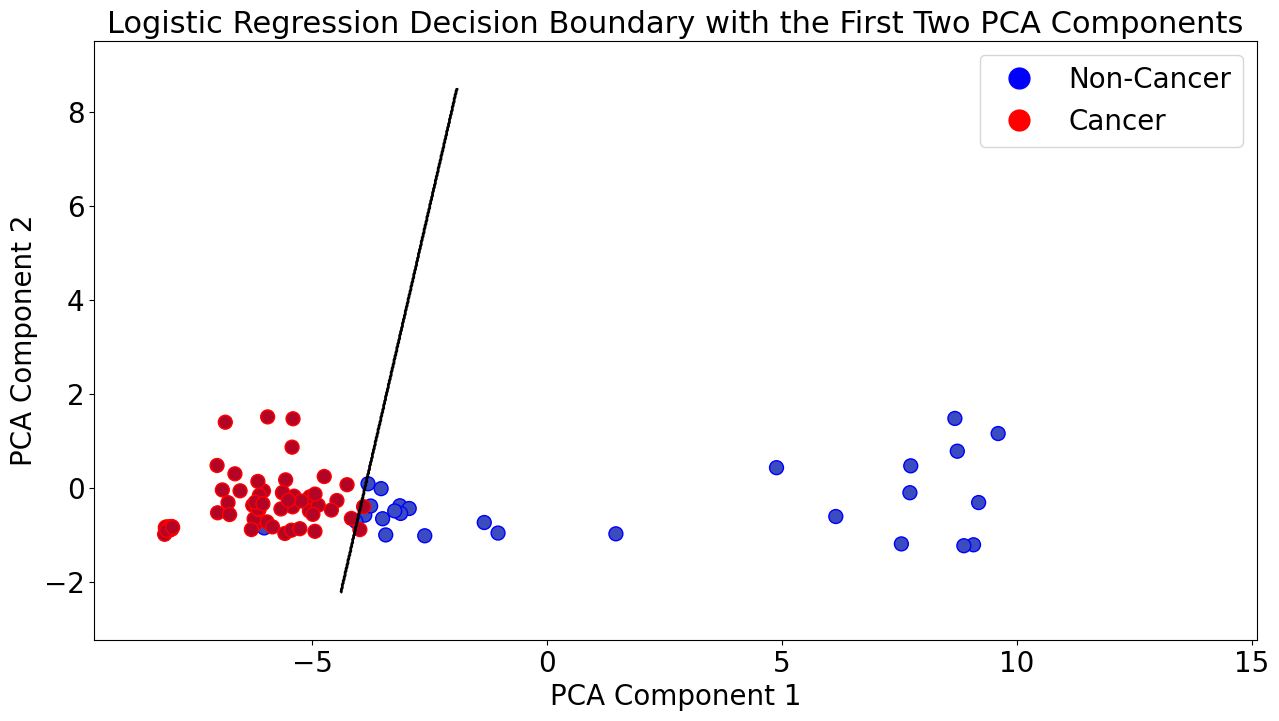

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy import stats

# Assuming X_pca is your PCA-reduced dataset and y contains the labels.

# Select the first two PCA components
X_for_visualization = X_pca[:, :2]

# Calculate z-scores for each feature in the data
z_scores = np.abs(stats.zscore(X_for_visualization))

# Define a threshold for z-score to identify outliers
threshold = 1  # You can adjust this threshold as needed

# Find the indices of outliers
outlier_indices = np.where(z_scores > threshold)

# Remove outliers from X_for_visualization and y
X_filtered = np.delete(X_for_visualization, outlier_indices[0], axis=0)
y_filtered = np.delete(y, outlier_indices[0])

# Retrain Logistic Regression on the filtered data
clf_lr_visualization = LogisticRegression()
clf_lr_visualization.fit(X_filtered, y_filtered)

# Set the figure face color to pure white
plt.figure(figsize=(15, 20), facecolor='white')

# Create a mesh to plot the decision boundary
x_min, x_max = X_filtered[:, 0].min() - 1, X_filtered[:, 0].max() + 5
y_min, y_max = X_filtered[:, 1].min() - 1, X_filtered[:, 1].max() + 7
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = clf_lr_visualization.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Increase point size in scatter plot
point_size = 100

# Plot only the decision boundary with white background
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5], colors='white', alpha=0.5)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

# Plot the data points without outliers with increased point size
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered, cmap='coolwarm',
            edgecolors=['blue' if label == 0 else 'red' for label in y_filtered],
            s=point_size)

# Customizing legend colors and labels with increased font size
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15, markeredgecolor='blue'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15, markeredgecolor='red')]
labels = ['Non-Cancer', 'Cancer']
legend = plt.legend(handles, labels, loc='upper right', fontsize=20)

# Increase text size for title and axis labels
plt.title('Logistic Regression Decision Boundary with the First Two PCA Components', fontsize=22)
plt.xlabel('PCA Component 1', fontsize=20)
plt.ylabel('PCA Component 2', fontsize=20)

# Adjust the plot limits with a buffer for better visibility
x_buffer = 0.5
y_buffer = 1.0
plt.xlim(x_min - x_buffer, x_max + x_buffer)
plt.ylim(y_min - y_buffer, y_max + y_buffer)

# Increase font size of x-axis tick labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


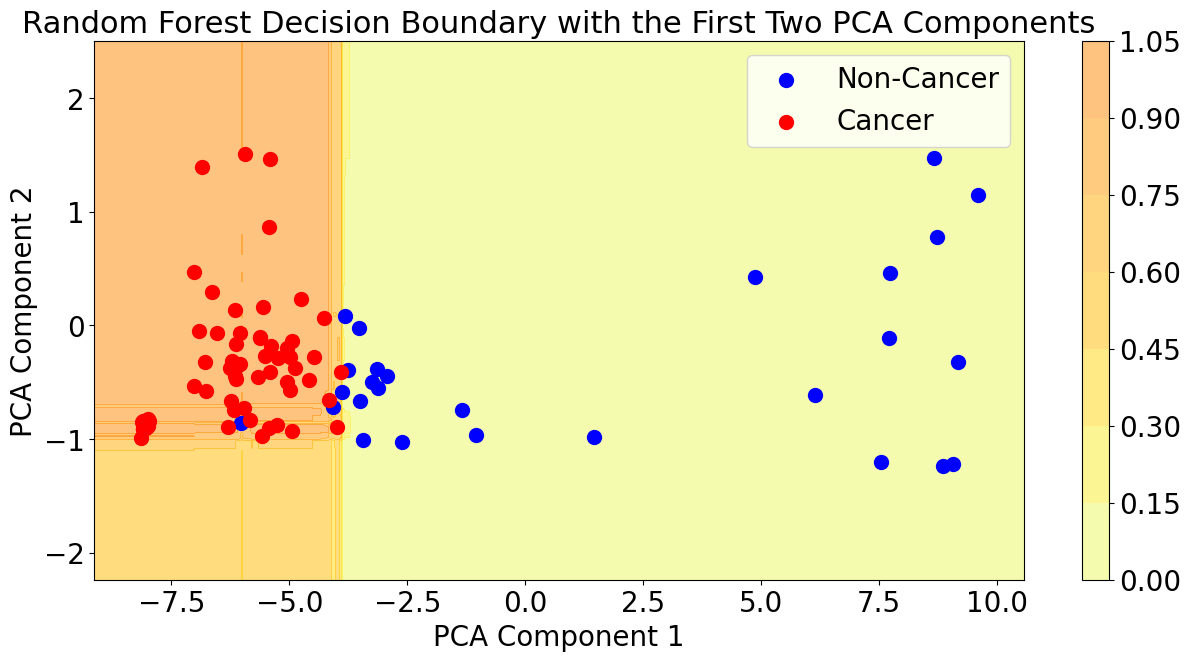

In [96]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming X_pca is your PCA-reduced dataset and y contains the labels.

# Select the first two PCA components
X_for_visualization = X_pca[:, :2]

# Calculate z-scores for each feature in the data
z_scores = np.abs(stats.zscore(X_for_visualization))

# Define a threshold for z-score to identify outliers
threshold = 1  # You can adjust this threshold as needed

# Find the indices of outliers
outlier_indices = np.where(z_scores > threshold)

# Remove outliers from X_for_visualization and y
X_filtered = np.delete(X_for_visualization, outlier_indices[0], axis=0)
y_filtered = np.delete(y, outlier_indices[0])

# Retrain Random Forest on the filtered data
clf_rf_visualization = RandomForestClassifier(n_estimators=100)  # Adjust parameters as needed
clf_rf_visualization.fit(X_filtered, y_filtered)

# Plotting
plt.figure(figsize=(15, 7))

# Increase point size in scatter plot
point_size = 100

# Create a mesh to plot the decision boundary
x_min, x_max = X_filtered[:, 0].min() - 1, X_filtered[:, 0].max() + 1
y_min, y_max = X_filtered[:, 1].min() - 1, X_filtered[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Obtain predicted probabilities for each point in the mesh
Z = clf_rf_visualization.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the decision boundary based on predicted probabilities
plt.contourf(xx, yy, Z, cmap='Wistia', alpha=0.5)  # Change colormap to 'coolwarm'
plt.colorbar().ax.tick_params(labelsize=20)  # Set font size for the colorbar ticks

# Define colors for cancer and non-cancer classes
colors = {0: 'blue', 1: 'red'}

# Plot data points with labels and increased point size
for label, color in colors.items():
    plt.scatter(X_filtered[y_filtered == label, 0], X_filtered[y_filtered == label, 1],
                c=color, label='Non-Cancer' if label == 0 else 'Cancer',
                edgecolors=color, s=point_size)  # Use the same color for edge and face

plt.legend(fontsize=20)

# Increase text size for title and axis labels
plt.title('Random Forest Decision Boundary with the First Two PCA Components', fontsize=22)
plt.xlabel('PCA Component 1', fontsize=20)
plt.ylabel('PCA Component 2', fontsize=20)

# Set the background color to white
plt.gca().set_facecolor('white')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


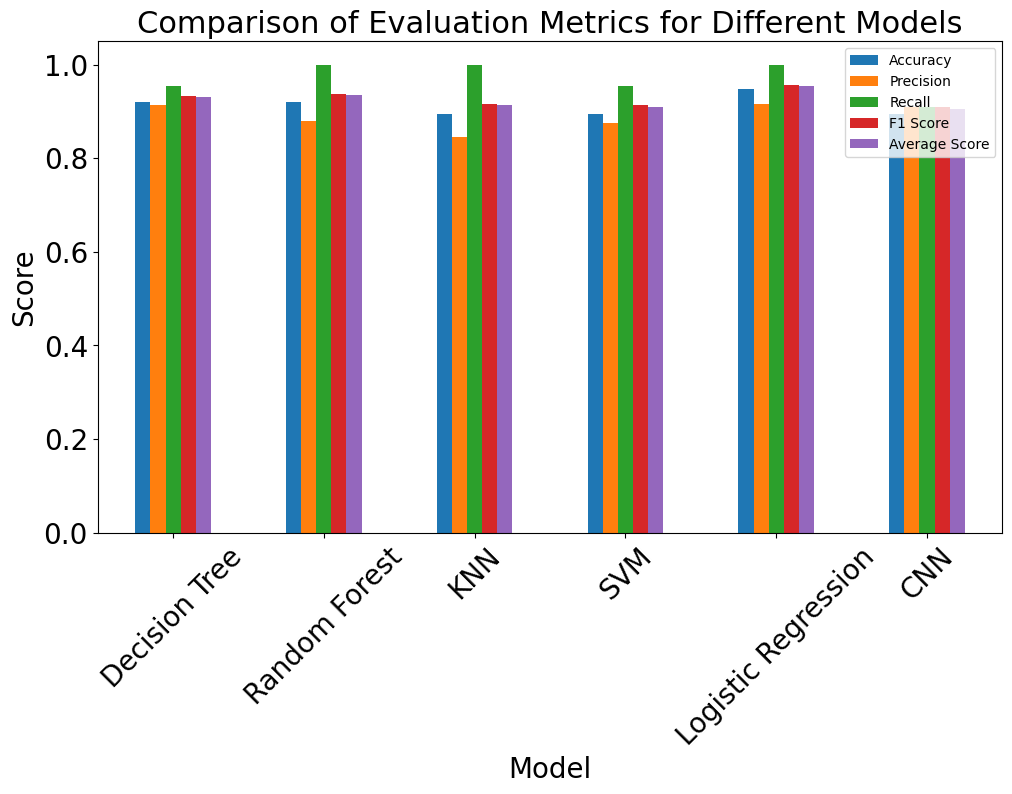

In [101]:
# Plotting comparison of evaluation metrics
metrics_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Average Score']].plot(kind='bar', figsize=(10, 7))
plt.title('Comparison of Evaluation Metrics for Different Models',fontsize=22)
plt.xlabel('Model',fontsize=20)
plt.ylabel('Score',fontsize=20)
legend = plt.legend(labels, fontsize=30)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()